In [279]:
# MOD per system
import sys
sys.path.append('C:/Users/emiga/OneDrive/Cal/GWs/code/holodeck') 


# %load ../init.ipy
%reload_ext autoreload
%autoreload 2
from importlib import reload

import os
import sys
import logging
import warnings
import numpy as np
import astropy as ap
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt

import h5py
import tqdm.notebook as tqdm

import kalepy as kale
import kalepy.utils
import kalepy.plot

import holodeck as holo
import holodeck.sam
from holodeck import cosmo, utils, plot
from holodeck.constants import MSOL, PC, YR, MPC, GYR

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
mpl.style.use('default')   # avoid dark backgrounds from dark theme vscode
plt.rcParams.update({'grid.alpha': 0.5})

log = holo.log
log.setLevel(logging.INFO)

## Calculate Test Strains
### Choose the frequency bins at which to calculate the GWB
same as in semi-analytic-models.ipynb

In [280]:
dur = 5.0*YR/3.1557600
cad = .5*YR/3.1557600
fobs = utils.nyquist_freqs(dur,cad)
fobs_edges = utils.nyquist_freqs_edges(dur,cad)
print(f"Number of frequency bins: {fobs.size-1}")
print(f"  between [{fobs[0]*YR:.2f}, {fobs[-1]*YR:.2f}] 1/yr")
print(f"          [{fobs[0]*1e9:.2f}, {fobs[-1]*1e9:.2f}] nHz")

Number of frequency bins: 4
  between [0.63, 3.16] 1/yr
          [20.00, 100.00] nHz


### Build Semi-Analytic-Model with super simple parameters 

In [281]:
exname = 'Example 2'

mtot=(1.0e6*MSOL/1.988409870698051, 1.0e8*MSOL/1.988409870698051, 3)
mrat=(1e-1, 1.0, 2)
redz=(1e-3, 1.0, 4)
sam = holo.sam.Semi_Analytic_Model(mtot, mrat, redz)
print('edges:', sam.edges)

edges: [array([1.e+39, 1.e+40, 1.e+41]), array([0.1, 1. ]), array([0.  , 0.01, 0.1 , 1.  ])]


### Get SAM edges and numbers as in sam.gwb()

In [282]:
# get observed orbital frequency bin edges and centers 
# from observed GW frequency bin edges
# f_orb = f_GW/2
fobs_orb_edges = fobs_edges / 2.0
fobs_orb_cents = kale.utils.midpoints(fobs_edges) / 2.0

# dynamic_binary_number
# gets differential number of binaries per bin-vol per log freq interval
edges, dnum = sam.dynamic_binary_number(holo.hardening.Hard_GW, fobs_orb=fobs_orb_cents)
edges[-1] = fobs_orb_edges

# integrate (multiply by bin volume) within each bin
number = utils._integrate_grid_differential_number(edges, dnum, freq=False)
number = number * np.diff(np.log(fobs_edges))

# 1 Functions

gws_by_loops

In [283]:
def gws_by_loops(edges, number, realize, round = False, sum=False, print_test = False):
       
    """ Inefficient way to calculate strain from numbered 
    grid integrated

    Parameters
    ----------
    edges : (4,) list of 1darrays
        A list containing the edges along each dimension.  The four dimensions correspond to
        total mass, mass ratio, redshift, and observer-frame orbital frequency.
        The length of each of the four arrays is M, Q, Z, F.
    number : (M-1, Q-1, Z-1, F-1) ndarray
        The number of binaries in each bin of parameter space.  This is calculated by integrating
        `dnum` over each bin.
    realize : bool or int,
        Specification of how to construct one or more discrete realizations.
        If a `bool` value, then whether or not to construct a realization.
        If a `int` value, then how many discrete realizations to construct.
    round : bool
        Specification of whether to discretize the sample if realize is False, 
        by rounding number of binaries in each bin to integers. This has no impact 
        if realize is true.
    sum : bool
        Whether or not to sum the strain at a given frequency over all bins.
    print_test : bool
        Whether or not to print variables as they are calculated, for dev purposes.


    Returns
    -------
    hc : ndarray
        Characteristic strain of the GWB.
        The shape depends on whether realize is an integer or not
        realize = True or False: shape is (M-1, Q-1, Z-1, F-1)
        realize = R: shape is  (M-1, Q-1, Z-1, F-1, R)

    """
    if(print_test):
        print('INPUTS: edges:', len(edges), '\n', edges, 
        '\nINPUTS:number:', number.shape, '\n', number,'\n')

    # Frequency bin midpoints
    foo = edges[-1]                   #: should be observer-frame orbital-frequencies
    df = np.diff(foo)                 #: frequency bin widths
    fc = kale.utils.midpoints(foo)    #: use frequency-bin centers for strain (more accurate!)

    # All other bin midpoints
    mt = kale.utils.midpoints(edges[0]) #: total mass
    mr = kale.utils.midpoints(edges[1]) #: mass ratio
    rz = kale.utils.midpoints(edges[2]) #: redshift

    
    # make strain grid
    hc_grid = np.empty_like(number)

    # for r realizations, make a grid with shape 
    # m, q, z, f, r
    if(utils.isinteger(realize)):
        newshape = hc_grid.shape + (realize,)
        if(print_test):
            print('newshape:', newshape)
        realized_grid = np.empty(newshape)

    # get strain for each bin
    for m_idx in range(len(mt)):
        for q_idx in range(len(mr)):
            cmass = holo.utils.chirp_mass_mtmr(mt[m_idx], mr[q_idx])
            for z_idx in range(len(rz)):
                cdist = holo.cosmo.comoving_distance(rz[z_idx]).cgs.value
                
                # print M, q, z, M_c, d_c
                if(print_test):
                    print('BIN mt=%.2e, mr=%.2e, rz=%.2e' %
                        (mt[m_idx], mr[q_idx], rz[z_idx]))
                    print('\t m_c = %.2e, d_c = %.2e' 
                        % (cmass, cdist))

                for f_idx in range(len(fc)):
                    rfreq = holo.utils.frst_from_fobs(fc[f_idx], rz[z_idx])
                    hs_mqzf = utils.gw_strain_source(cmass, cdist, rfreq)
                    hc_dlnf = hs_mqzf**2 * (fc[f_idx]/df[f_idx])
                    
                    if(realize == False):
                        if(round == True):
                            hc_grid[m_idx, q_idx, z_idx, f_idx] = np.sqrt(hc_dlnf 
                                        * np.floor(number[m_idx, q_idx, z_idx, f_idx]).astype(int))
                        else:
                            hc_grid[m_idx, q_idx, z_idx, f_idx] = np.sqrt(hc_dlnf 
                                        * number[m_idx, q_idx, z_idx, f_idx])
                        
                    elif(realize == True):
                        hc_grid[m_idx, q_idx, z_idx, f_idx] = np.sqrt(hc_dlnf 
                                        *np.random.poisson(number[m_idx, q_idx, z_idx, f_idx]))
                    elif(utils.isinteger(realize)):
                        for r_idx in range(realize):
                            realized_grid[m_idx, q_idx, z_idx, f_idx, r_idx] = \
                                np.sqrt(hc_dlnf 
                                        *np.random.poisson(number[m_idx, q_idx, z_idx, f_idx]))
                        hc_grid = realized_grid                
                    else:
                        print("`realize` ({}) must be one of {{True, False, integer}}!"\
                            .format(realize))

                     # print fr, hs, hc^2/dlnf, number, hc
                    if(print_test):
                        print('\t\tfr = %.2fnHz, h_s = %.2e, h_c^2/dlnf = %.2e' 
                            % (rfreq*10**9, hs_mqzf, hc_dlnf))
                        print('\t\tnumber: %.2e' % number[m_idx, q_idx, z_idx, f_idx])
                        print('\t\thc = %.2e' % hc_grid[m_idx, q_idx, z_idx, f_idx])
    if(sum):
        # sum over all bins at a given frequency and realization
        hc_grid = np.sqrt(np.sum(hc_grid**2, axis=(0, 1, 2)))

    
    return hc_grid


cleaned up loops

In [317]:
def ss_gws_by_loops(edges, number, realize=False, round=True, sum=True, 
                    ss=True, print_test = False):
       
    """ Inefficient way to calculate strain from numbered 
    grid integrated

    Parameters
    ----------
    edges : (4,) list of 1darrays
        A list containing the edges along each dimension.  The four dimensions correspond to
        total mass, mass ratio, redshift, and observer-frame orbital frequency.
        The length of each of the four arrays is M, Q, Z, F.
    number : (M-1, Q-1, Z-1, F-1) ndarray
        The number of binaries in each bin of parameter space.  This is calculated by integrating
        `dnum` over each bin.
    realize : bool or int,
        Specification of how to construct one or more discrete realizations.
        If a `bool` value, then whether or not to construct a realization.
        If a `int` value, then how many discrete realizations to construct.
    round : bool
        Specification of whether to discretize the sample if realize is False, 
        by rounding number of binaries in each bin to integers. This has no impact 
        if realize is true.
    sum : bool
        Whether or not to sum the strain at a given frequency over all bins.
    ss : bool 
        Whether or not to separate the loudest single source in each frequency bin.
        NOTE: would be good to update this to allow for multiple foreground sources.
    print_test : bool
        Whether or not to print variable as they are calculated, for dev purposes.


    Returns
    -------
    hc : ndarray
        Characteristic strain of the GWB.
        The shape depends on whether realize is an integer or not
        realize = True or False, sum = False: shape is (M-1, Q-1, Z-1, F-1)
        realize = True or False, sum = True: shape is (F-1)
        realize = R, sum = False: shape is  (M-1, Q-1, Z-1, F-1, R)
        realize = R, sum = True: shape is  (F-1, R)
    louds : (F-1, 3) ndarray or None
        M, q, and z of the loudest single source in each frequency bin.
        None if loud = False


    """
    if(print_test):
        print('INPUTS: edges:', len(edges), '\n', edges, 
        '\nINPUTS:number:', number.shape, '\n', number,'\n')

    # Frequency bin midpoints
    foo = edges[-1]                   #: should be observer-frame orbital-frequencies
    df = np.diff(foo)                 #: frequency bin widths
    fc = kale.utils.midpoints(foo)    #: use frequency-bin centers for strain (more accurate!)

    # All other bin midpoints
    mt = kale.utils.midpoints(edges[0]) #: total mass
    mr = kale.utils.midpoints(edges[1]) #: mass ratio
    rz = kale.utils.midpoints(edges[2]) #: redshift

    
    # GW background characteristic strain
    hc_bg = np.empty_like(number)
    new_num = np.copy(number)

    # for single sources, make a grid with shape
    # (f, 3)
    if(ss == True):
        # params of loudest bin with number>=1
        # shape (f,3) for 3 params
        sspar = np.empty((len(fc), 3)) 
        # param indices of loudest bin with number>=1
        # shape (f,3) for 3 params
        ssidx = np.empty((len(fc), 3)) 
        # max hs at each frequency
        maxhs = np.zeros(len(fc))
        # (max)  single source characteristic strain at each frequency
        hc_ss = np.zeros(len(fc))
    else: 
        sspar = None
        ssidx = None
        maxhs = None
        hc_ss = None

    # # not worrying about realization implementation yet
    # # for r realizations, make a grid with shape 
    # # m, q, z, f, r
    # if(utils.isinteger(realize)):
    #     newshape = hc_grid.shape + (realize,)
    #     if(print_test):
    #         print('newshape:', newshape)
    #     realized_grid = np.empty(newshape)


    # --------------- Single Sources ------------------
    # 1) Identify the loudest (max hs) single source in a bin with N>=1
    # 2) Record the parameters, parameter indices, and strain
    #  of that single source
    # 3) Subtract 1 from the number in that source's bin, 
    # 4) Calculate single source characteristic strain (hc)
    # 5) Calculate the background with the new number 
    
    if(ss == True):
        for m_idx in range(len(mt)):
            for q_idx in range(len(mr)):
                cmass = holo.utils.chirp_mass_mtmr(mt[m_idx], mr[q_idx])
                for z_idx in range(len(rz)):
                    cdist = holo.cosmo.comoving_distance(rz[z_idx]).cgs.value
                    
                    # print M, q, z, M_c, d_c
                    if(print_test):
                        print('BIN mt=%.2e, mr=%.2e, rz=%.2e' %
                            (mt[m_idx], mr[q_idx], rz[z_idx]))
                        print('\t m_c = %.2e, d_c = %.2e' 
                            % (cmass, cdist))

                    # check if loudest source in any bin
                    for f_idx in range(len(fc)):
                        rfreq = holo.utils.frst_from_fobs(fc[f_idx], rz[z_idx])
                        # hs of a source in that bin
                        hs_mqzf = utils.gw_strain_source(cmass, cdist, rfreq)
                        
                        # 1) IF LOUDEST
                        # check if loudest hs at that 
                        # frequency and contains binaries
                        if(hs_mqzf>maxhs[f_idx] and 
                           number[m_idx, q_idx, z_idx, f_idx]>=1):
                            
                            # 2) If so, RECORD:
                            # parameters M, q, z
                            sspar[f_idx] = np.array([mt[m_idx], mr[q_idx],
                                                     rz[z_idx]])
                            # parameter indices
                            ssidx[f_idx] = np.array([m_idx, q_idx, z_idx])
                            # new max strain
                            maxhs[f_idx] = hs_mqzf

                    # print fr, hs, hc^2/dlnf, number, hc
                    # if(print_test):
                    #     print('\tfr = %.2fnHz, h_s = %.2e'
                    #         % (rfreq*10**9, hs_mqzf))
                    #     print('\t\tnumber: %.2e' % 
                    #           number[m_idx, q_idx, z_idx, f_idx])
                    #     if(ss):
                    #         print('\t\thsmax = %.2e, max indices = (%d,%d,%d)' 
                    #             % (maxhs[f_idx], ssidx[f_idx,0], 
                    #                ssidx[f_idx,1], ssidx[f_idx,2]))

        # 3) SUBTRACT 1 
        # from bin with loudest source at each frequency
        # can do this using the index of loudest, ssidx
        # recall ssidx has shape [3, F]
        # and = [(m_idx,q_idx,z_idx), fc],
        for f_idx in range(len(fc)):
            new_num[int(ssidx[f_idx,0]), int(ssidx[f_idx,1]), int(ssidx[f_idx,2]), 
                    f_idx] = number[int(ssidx[f_idx,0]), int(ssidx[f_idx,1]),
                                     int(ssidx[f_idx,2]), f_idx] - 1 
            # print('ssidx=', int(ssidx[f_idx,0]), int(ssidx[f_idx,1]), int(ssidx[f_idx,2]), f_idx)
            # print(new_num.shape)
            # print(new_num[int(ssidx[f_idx,0]), int(ssidx[f_idx,1]), int(ssidx[f_idx,2]), f_idx])

            # 4) CALCULATE 
            # single source characteristic strain
            hc_ss[f_idx] = np.sqrt(maxhs[f_idx]**2 * (fc[f_idx]/df[f_idx]))
            

    # 5)
    # ----------------- Calculate Background Strains --------------------
    # then we can go back in and calculate characteristic strains
    # NOTE: could make this faster by saving rfreq and hs values from above
    # instead of recalculating
    for m_idx in range(len(mt)):
        for q_idx in range(len(mr)):
            cmass = holo.utils.chirp_mass_mtmr(mt[m_idx], mr[q_idx])
            for z_idx in range(len(rz)):
                cdist = holo.cosmo.comoving_distance(rz[z_idx]).cgs.value
                for f_idx in range(len(fc)):
                    rfreq = holo.utils.frst_from_fobs(fc[f_idx], rz[z_idx])
                    hs_mqzf = utils.gw_strain_source(cmass, cdist, rfreq)
                    hc_dlnf = hs_mqzf**2 * (fc[f_idx]/df[f_idx])
                    if(realize == False):
                        if(round == True):
                            hc_bg[m_idx, q_idx, z_idx, f_idx] = np.sqrt(hc_dlnf 
                                        * np.floor(new_num[m_idx, q_idx, z_idx, f_idx]).astype(int))
                        else:
                            hc_bg[m_idx, q_idx, z_idx, f_idx] = np.sqrt(hc_dlnf 
                                        * new_num[m_idx, q_idx, z_idx, f_idx])
                    else: 
                        print('realize not implemented yet') 
                        return 0   
                    # elif(realize == True):
                    #     hc_grid[m_idx, q_idx, z_idx, f_idx] = np.sqrt(hc_dlnf 
                    #                     *np.random.poisson(new_num[m_idx, q_idx, z_idx, f_idx]))
                    # elif(utils.isinteger(realize)):
                    #     for r_idx in range(realize):
                    #         realized_grid[m_idx, q_idx, z_idx, f_idx, r_idx] = \
                    #             np.sqrt(hc_dlnf 
                    #                     *np.random.poisson(new_num[m_idx, q_idx, z_idx, f_idx]))
                    #     hc_grid = realized_grid                
                    # else:
                    #     print("`realize` ({}) must be one of {{True, False, integer}}!"\
                    #         .format(realize))

                    if(print_test):
                        print('\tfr = %.2fnHz, h_s = %.2e, h_c^2/dlnf = %.2e' 
                            % (rfreq*10**9, hs_mqzf, hc_dlnf))
                        print('\t\tnumber: %.2e' % new_num[m_idx, q_idx, z_idx, f_idx])
                        print('\t\thc = %.2e' % hc_bg[m_idx, q_idx, z_idx, f_idx])
                        if(ss == True):
                            print('\t\t loudest?', 
                                np.all((ssidx[f_idx] == np.array([m_idx, q_idx, z_idx]))))
    if(ss and print_test):
        print('----loudest bins:')
        for f_idx in range(len(fc)):
            print('\t M=%.2e, q=%.2e, z=%.2e, f=%.2e' 
                    % (sspar[f_idx,0], sspar[f_idx,1], sspar[f_idx,2], fc[f_idx]))
            # if we use this instead, we don't need sspar
            # print('\t M=%.2e, q=%.2e, z=%.2e, f=%.2e' 
            #       % (mt[ssidx[f_idx,0]], mr[ssidx[f_idx,1]], rz[ssidx[f_idx,2]]))

     
    if(sum):
        # sum over all bins at a given frequency and realization
        hc_bg = np.sqrt(np.sum(hc_bg**2, axis=(0, 1, 2)))

    
    return hc_bg, hc_ss, sspar, ssidx, maxhs, new_num


In [290]:
def gws_by_ndars(edges, number, realize, round = False, sum = False, print_test = False):
       
    """ More efficient way to calculate strain from numbered 
    grid integrated

    Parameters
    ----------
    edges : (4,) list of 1darrays
        A list containing the edges along each dimension.  The four dimensions 
        correspond to total mass, mass ratio, redshift, and observer-frame orbital 
        frequency. The length of each of the four arrays is M, Q, Z, F.
    number : (M-1, Q-1, Z-1, F-1) ndarray
        The number of binaries in each bin of parameter space.  This is calculated 
        by integrating `dnum` over each bin.
    realize : bool or int
        Specification of how to construct one or more discrete realizations.
        If a `bool` value, then whether or not to construct a realization.
        If an `int` value, then how many discrete realizations to construct.
    round : bool
        Specification of whether to discretize the sample if realize is False, 
        by rounding number of binaries in each bin to integers. This has no impact 
        if realize is true.
    sum : bool
        Whether or not to sum the strain at a given frequency over all bins.
    print_test : bool
        Whether or not to print variable as they are calculated, for dev purposes.


    Returns
    -------
    hc : ndarray
        Characteristic strain of the GWB.
        The shape depends on whether realize is an integer or not
        realize = True or False, sum = False: shape is (M-1, Q-1, Z-1, F-1)
        realize = True or False, sum = True: shape is (F-1)
        realize = R, sum = False: shape is  (M-1, Q-1, Z-1, F-1, R)
        realize = R, sum = True: shape is  (F-1, R)

    """

    if(print_test):
        print('INPUTS: edges:', len(edges), # '\n', edges, 
        '\nINPUTS:number:', number.shape, '\n', number,'\n')

    # Frequency bin midpoints
    foo = edges[-1]                   #: should be observer-frame orbital-frequencies
    df = np.diff(foo)                 #: frequency bin widths
    fc = kale.utils.midpoints(foo)    #: use frequency-bin centers for strain (more accurate!)

    # All other bin midpoints
    mt = kale.utils.midpoints(edges[0]) #: total mass
    mr = kale.utils.midpoints(edges[1]) #: mass ratio
    rz = kale.utils.midpoints(edges[2]) #: redshift


    # --- Chirp Masses ---
    # to get chirp mass in shape (M-1, Q-1) we need 
    # mt in shape (M-1, 1) 
    # mr in shape (1, Q-1)
    cmass = utils.chirp_mass_mtmr(mt[:,np.newaxis], mr[np.newaxis,:])
    if(print_test):
        print('cmass:', cmass.shape, '\n', cmass)

    # --- Comoving Distances ---
    # to get cdist in shape (Z-1) we need
    # rz in shape (Z-1)
    cdist = holo.cosmo.comoving_distance(rz).cgs.value
    if(print_test):
        print('cdist:', cdist.shape, '\n', cdist)

    # --- Rest Frame Frequencies ---
    # to get rest freqs in shape (Z-1, F-1) we need 
    # rz in shape (Z-1, 1) 
    # fc in shape (1, F-1)
    rfreq = holo.utils.frst_from_fobs(fc[np.newaxis,:], rz[:,np.newaxis])
    if(print_test):
        print('rfreq:', rfreq.shape, '\n', rfreq)

    # --- Source Strain Amplitude ---
    # to get hs amplitude in shape (M-1, Q-1, Z-1, F-1) we need
    # cmass in shape (M-1, Q-1, 1, 1) from (M-1, Q-1)
    # cdist in shape (1, 1, Z-1, 1) from (Z-1)
    # rfreq in shape (1, 1, Z-1, F-1) from (Z-1, F-1)
    hsamp = utils.gw_strain_source(cmass[:,:,np.newaxis,np.newaxis],
                                   cdist[np.newaxis,np.newaxis,:,np.newaxis],
                                   rfreq[np.newaxis,np.newaxis,:,:])
    if(print_test):
        print('hsamp', hsamp.shape, '\n', hsamp)

    # --- Characteristic Strain Squared ---
    # to get characteristic strain in shape (M-1, Q-1, Z-1, F-1) we need
    # hsamp in shape (M-1, Q-1, Z-1, F-1)
    # fc in shape (1, 1, 1, F-1)
    hchar = hsamp**2 * (fc[np.newaxis, np.newaxis, np.newaxis,:]
                        /df[np.newaxis, np.newaxis, np.newaxis,:])

    # Sample:
    if(realize == False):
        # without sampling, want strain in shape (M-1, Q-1, Z-1, F-1)
        if(round): 
            # discretize by rounding number down to nearest integer 
            hchar *= np.floor(number).astype(int) 
        else: 
            # keep non-integer values
            hchar *= number

    if(realize == True):
        # with a single sample, want strain in shape (M-1, Q-1, Z-1, F-1)
        hchar *= np.random.poisson(number)

    if(utils.isinteger(realize)):
        # with R realizations, 
        # to get strain in shape (M-1, Q-1, Z-1, F-1, R) we need
        # hchar in shape(M-1, Q-1, Z-1, F-1, 1)
        # Poisson sample in shape (1, 1, 1, 1, R)
        npois = np.random.poisson(number[...,np.newaxis], size = (number.shape + (realize,)))
        if(print_test):
            print('npois', npois.shape)
        hchar = hchar[...,np.newaxis] * npois


    if(print_test):
        print('hchar', hchar.shape, '\n', hchar)


    if(sum):
        # sum over all bins at a given frequency and realization
        hchar = np.sum(hchar, axis=(0, 1, 2))
        # NOTE I should check what big O time this is,  not sure
        if(print_test):
            print('hchar summed', hchar.shape, '\n', hchar)

    return np.sqrt(hchar)

some edits for loud_gws:
* no longer makes sense to have a sum=False option


##### ss ndars

In [291]:
def ss_gws_by_ndars(edges, number, realize, round = False, sum = True, 
                    loud = True, print_test = False):
       
    """ More efficient way to calculate strain from numbered 
    grid integrated

    Parameters
    ----------
    edges : (4,) list of 1darrays
        A list containing the edges along each dimension.  The four dimensions 
        correspond to total mass, mass ratio, redshift, and observer-frame orbital 
        frequency. The length of each of the four arrays is M, Q, Z, F.
    number : (M-1, Q-1, Z-1, F-1) ndarray
        The number of binaries in each bin of parameter space.  This is calculated 
        by integrating `dnum` over each bin.
    realize : bool or int
        Specification of how to construct one or more discrete realizations.
        If a `bool` value, then whether or not to construct a realization.
        If an `int` value, then how many discrete realizations to construct.
    round : bool
        Specification of whether to discretize the sample if realize is False, 
        by rounding number of binaries in each bin to integers. This has no impact 
        if realize is true.
    sum : bool
        Whether or not to sum the strain at a given frequency over all bins.
    loud : bool 
        Whether or not to separate the loudest single source in each frequency bin.
        NOTE: would be good to update this to allow for multiple foreground sources.
    print_test : bool
        Whether or not to print variable as they are calculated, for dev purposes.


    Returns
    -------
    hchar : ndarray
        Characteristic strain of the GWB.
        The shape depends on whether realize is an integer or not
        realize = True or False, sum = False: shape is (M-1, Q-1, Z-1, F-1)
        realize = True or False, sum = True: shape is (F-1)
        realize = R, sum = False: shape is  (M-1, Q-1, Z-1, F-1, R)
        realize = R, sum = True: shape is  (F-1, R)
    louds : (3,F-1) ndarray or None
        Parameters of the loudest single source in each frequency bin.
        None if loud = False

    """

    if(print_test):
        print('INPUTS: edges:', len(edges), # '\n', edges, 
        '\nINPUTS:number:', number.shape, '\n', number,'\n')

    # Frequency bin midpoints
    foo = edges[-1]                   #: should be observer-frame orbital-frequencies
    df = np.diff(foo)                 #: frequency bin widths
    fc = kale.utils.midpoints(foo)    #: use frequency-bin centers for strain (more accurate!)

    # All other bin midpoints
    mt = kale.utils.midpoints(edges[0]) #: total mass
    mr = kale.utils.midpoints(edges[1]) #: mass ratio
    rz = kale.utils.midpoints(edges[2]) #: redshift


    # --- Chirp Masses ---
    # to get chirp mass in shape (M-1, Q-1) we need 
    # mt in shape (M-1, 1) 
    # mr in shape (1, Q-1)
    cmass = utils.chirp_mass_mtmr(mt[:,np.newaxis], mr[np.newaxis,:])
    if(print_test):
        print('cmass:', cmass.shape, '\n', cmass)

    # --- Comoving Distances ---
    # to get cdist in shape (Z-1) we need
    # rz in shape (Z-1)
    cdist = holo.cosmo.comoving_distance(rz).cgs.value
    if(print_test):
        print('cdist:', cdist.shape, '\n', cdist)

    # --- Rest Frame Frequencies ---
    # to get rest freqs in shape (Z-1, F-1) we need 
    # rz in shape (Z-1, 1) 
    # fc in shape (1, F-1)
    rfreq = holo.utils.frst_from_fobs(fc[np.newaxis,:], rz[:,np.newaxis])
    if(print_test):
        print('rfreq:', rfreq.shape, '\n', rfreq)

    # --- Source Strain Amplitude ---
    # to get hs amplitude in shape (M-1, Q-1, Z-1, F-1) we need
    # cmass in shape (M-1, Q-1, 1, 1) from (M-1, Q-1)
    # cdist in shape (1, 1, Z-1, 1) from (Z-1)
    # rfreq in shape (1, 1, Z-1, F-1) from (Z-1, F-1)
    hsamp = utils.gw_strain_source(cmass[:,:,np.newaxis,np.newaxis],
                                   cdist[np.newaxis,np.newaxis,:,np.newaxis],
                                   rfreq[np.newaxis,np.newaxis,:,:])
    if(print_test):
        print('hsamp', hsamp.shape, '\n', hsamp)

    if(loud == True):
        louds = np.empty((3,len(fc)))

    # --- Characteristic Strain Squared ---
    # to get characteristic strain in shape (M-1, Q-1, Z-1, F-1) we need
    # hsamp in shape (M-1, Q-1, Z-1, F-1)
    # fc in shape (1, 1, 1, F-1)
    hchar = hsamp**2 * (fc[np.newaxis, np.newaxis, np.newaxis,:]
                        /df[np.newaxis, np.newaxis, np.newaxis,:])

    # Sample:
    if(realize == False):
        # without sampling, want strain in shape (M-1, Q-1, Z-1, F-1)
        if(round): 
            # discretize by rounding number down to nearest integer 
            hchar *= np.floor(number).astype(int) 
        else: 
            # keep non-integer values
            hchar *= number

    if(realize == True):
        # with a single sample, want strain in shape (M-1, Q-1, Z-1, F-1)
        hchar *= np.random.poisson(number)

    if(utils.isinteger(realize)):
        # with R realizations, 
        # to get strain in shape (M-1, Q-1, Z-1, F-1, R) we need
        # hchar in shape(M-1, Q-1, Z-1, F-1, 1)
        # Poisson sample in shape (1, 1, 1, 1, R)
        npois = np.random.poisson(number[...,np.newaxis], size = (number.shape + (realize,)))
        if(print_test):
            print('npois', npois.shape)
        hchar = hchar[...,np.newaxis] * npois


    if(print_test):
        print('hchar', hchar.shape, '\n', hchar)


    if(sum):
        # sum over all bins at a given frequency and realization
        hchar = np.sum(hchar, axis=(0, 1, 2))
        # NOTE I should check what big O time this is,  not sure
        if(print_test):
            print('hchar summed', hchar.shape, '\n', hchar)

    return np.sqrt(hchar)

# 2 Super Simple Example 

In [319]:
exname = 'Example 2'

### Choose the frequency bins at which to calculate the GWB
same as in semi-analytic-models.ipynb

In [320]:
dur = 5.0*YR/3.1557600
cad = .5*YR/3.1557600
fobs = utils.nyquist_freqs(dur,cad)
fobs_edges = utils.nyquist_freqs_edges(dur,cad)
print(f"Number of frequency bins: {fobs.size-1}")
print(f"  between [{fobs[0]*YR:.2f}, {fobs[-1]*YR:.2f}] 1/yr")
print(f"          [{fobs[0]*1e9:.2f}, {fobs[-1]*1e9:.2f}] nHz")

Number of frequency bins: 4
  between [0.63, 3.16] 1/yr
          [20.00, 100.00] nHz


### Build Semi-Analytic-Model with super simple parameters 

In [321]:
exname = 'Example 2'

mtot=(1.0e6*MSOL/1.988409870698051, 1.0e8*MSOL/1.988409870698051, 3)
mrat=(1e-1, 1.0, 2)
redz=(1e-3, 1.0, 4)
sam = holo.sam.Semi_Analytic_Model(mtot, mrat, redz)
print('edges:', sam.edges)

edges: [array([1.e+39, 1.e+40, 1.e+41]), array([0.1, 1. ]), array([0.  , 0.01, 0.1 , 1.  ])]


### Get SAM edges and numbers as in sam.gwb()

In [322]:
# get observed orbital frequency bin edges and centers 
# from observed GW frequency bin edges
# f_orb = f_GW/2
fobs_orb_edges = fobs_edges / 2.0
fobs_orb_cents = kale.utils.midpoints(fobs_edges) / 2.0

# dynamic_binary_number
# gets differential number of binaries per bin-vol per log freq interval
edges, dnum = sam.dynamic_binary_number(holo.hardening.Hard_GW, fobs_orb=fobs_orb_cents)
edges[-1] = fobs_orb_edges

# integrate (multiply by bin volume) within each bin
number = utils._integrate_grid_differential_number(edges, dnum, freq=False)
number = number * np.diff(np.log(fobs_edges))

### Calculate strains

In [327]:
# 1. Get GW Total Strain using gws_by_ndars()
hc_tt = gws_by_ndars(edges, number, realize=False, round = True, sum=True)   
 
# Get bg (background) and ss (single source) strains by ss_gws_by_loops_ugly
hc_bg_ugly, hc_ss_ugly, sspar_ugy, ssidx_ugly, maxhs_ugly = ss_gws_by_loops_ugly(edges, number, realize=False, round=True, ss=True, print_test=True, sum=True)

# cleaan
hc_bg, hc_ss, sspar, ssidx, maxhs, number_bg  = ss_gws_by_loops(edges, number, realize=False, round=True, sum=True, ss=True)

INPUTS: edges: 4 
 [array([1.e+39, 1.e+40, 1.e+41]), array([0.1, 1. ]), array([0.  , 0.01, 0.1 , 1.  ]), array([5.0e-09, 1.5e-08, 2.5e-08, 3.5e-08, 4.5e-08, 6.0e-08])] 
INPUTS:number: (2, 1, 3, 5) 
 [[[[0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
   [8.83e+06 6.46e+05 1.44e+05 5.01e+04 2.78e+04]
   [1.09e+09 8.01e+07 1.79e+07 6.21e+06 3.44e+06]]]


 [[[0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
   [1.10e+05 8.05e+03 1.80e+03 6.24e+02 3.46e+02]
   [1.29e+07 9.45e+05 2.11e+05 7.32e+04 4.06e+04]]]] 

[[4.04e-306 5.40e-315 5.93e-305]
 [1.37e-308 3.96e-316 2.00e-308]
 [3.06e-309 8.84e-317 4.48e-309]
 [1.06e-309 3.07e-317 1.55e-309]
 [5.89e-310 1.70e-317 8.61e-310]]
BIN mt=5.50e+39, mr=5.50e-01, rz=5.50e-03
	 m_c = 2.27e+39, d_c = 7.33e+25
	fr = 10.06nHz, h_s = 2.92e-19
		number: 0.00e+00
		hsmax = 0.00e+00, max indices = (0,0,0)
	fr = 20.11nHz, h_s = 4.64e-19
		number: 0.00e+00
		hsmax = 0.00e+00, max indices = (0,0,0)
	fr = 30.17nHz, h_s = 6.07e-19
		number: 0.00e+00
		hsmax = 0.00e+0

## 2.3 Test Plots

### BG, SS, and TT Strain

5


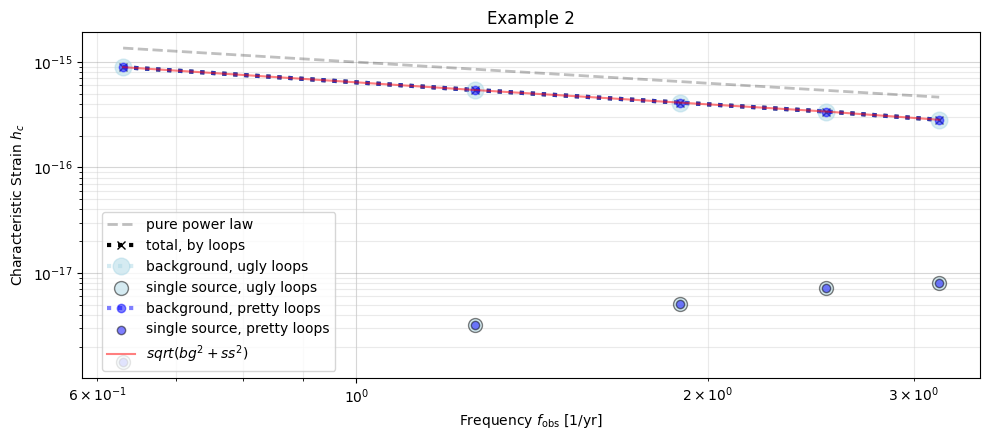

In [328]:
# quick plot
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])
ax.set_title(exname)
xx = fobs * YR
print(len(hc_bg_ugly))

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# total char strain (no sources subtracted)
ax.plot(xx, hc_tt, color='black', marker = 'x', lw=3, ls = 'dotted', alpha=1, label='total, by loops')

# gwb
ax.plot(xx, hc_bg_ugly, color='lightblue', marker = 'o', lw=3, ms=12,
        ls = 'dotted', alpha=.5, label='background, ugly loops')
# loudest source per bin
ax.scatter(xx, hc_ss_ugly, color='lightblue', marker = 'o', s=100,
           edgecolor='k', alpha=.5, label='single source, ugly loops')


# gwb
ax.plot(xx, hc_bg, color='b', marker = 'o', lw=3, ls = 'dotted', alpha=.5, label='background, pretty loops')
# loudest source per bin
ax.scatter(xx, hc_ss, color='b', marker = 'o', edgecolor='k', alpha=.5, label='single source, pretty loops')


# ax.plot(xx, hc_bg+hc_ss, color='r', label='bg + ss', alpha=.5)
ax.plot(xx, np.sqrt(hc_bg**2+hc_ss**2), color='r', label=r'$sqrt (bg^2 + ss^2)$', alpha=.5)

legend_gwb = ax.legend(bbox_to_anchor=(.1,.15), bbox_transform=fig.transFigure, loc='lower left')


# ax.set_ylim(1e-16, 3e-15)
fig.tight_layout()

##### number - number_bg check

(2, 1, 3)
(2, 1, 3)


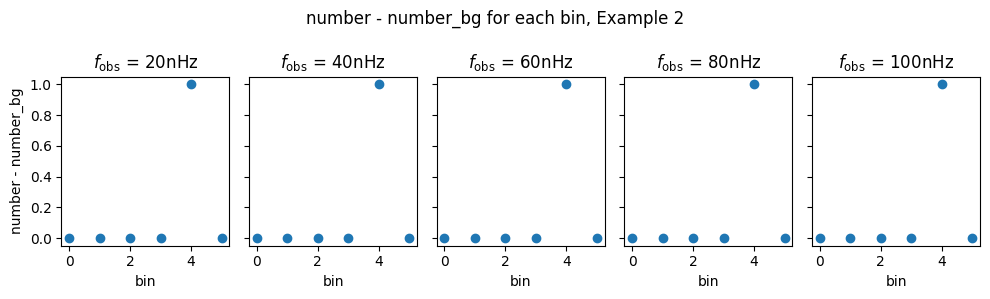

In [298]:
# plot number vs anything at 1 frequency 
freqs_in_nHz = fobs*10**9
# plot number - single sources vs anything at 1 frequency,
# should only vary in one cell
fig, ax = plt.subplots(1,len(fobs), figsize = (10,3), sharey=True)
fig.suptitle('number - number_bg for each bin, '+ exname)
ax[0].set_ylabel('number - number_bg')
bins = np.arange(0, number[...,0].size, 1)
bins = np.reshape(bins, number[...,0].shape)
print(bins.shape)
print(number[...,0].shape)
for f in range(len(fobs)):
    ax[f].scatter(bins, (number[...,f] - number_bg[...,f]))
    ax[f].set_title('$f_\mathrm{obs}$ = %dnHz' % freqs_in_nHz[f])
    ax[f].set_xlabel('bin')
fig.tight_layout()


# 3 Slightly More Complex Example
Let's see what windows can handle. Limiting factor seems to be the total mass upper limit.

In [299]:
exname = 'Example 3'

## 3.1 Calculate Strains
### Choose the frequency bins at which to calculate the GWB
same as in semi-analytic-models.ipynb

In [300]:
dur = 5.0*YR/3.1557600
cad = .5*YR/3.1557600
fobs = utils.nyquist_freqs(dur,cad)
fobs_edges = utils.nyquist_freqs_edges(dur,cad)
print(f"Number of frequency bins: {fobs.size-1}")
print(f"  between [{fobs[0]*YR:.2f}, {fobs[-1]*YR:.2f}] 1/yr")
print(f"          [{fobs[0]*1e9:.2f}, {fobs[-1]*1e9:.2f}] nHz")

Number of frequency bins: 4
  between [0.63, 3.16] 1/yr
          [20.00, 100.00] nHz


### Build Semi-Analytic-Model with super simple parameters 

In [301]:
mtot=(1.0e6*MSOL/1.988409870698051, 4.0e9*MSOL, 25)
mrat=(1e-1, 1.0, 25)
redz=(1e-3, 10.0, 25)
sam = holo.sam.Semi_Analytic_Model(mtot, mrat, redz)
print('edges:', sam.edges)

edges: [array([1.00e+39, 1.45e+39, 2.11e+39, 3.07e+39, 4.47e+39, 6.50e+39,
       9.44e+39, 1.37e+40, 2.00e+40, 2.90e+40, 4.22e+40, 6.13e+40,
       8.92e+40, 1.30e+41, 1.89e+41, 2.74e+41, 3.98e+41, 5.79e+41,
       8.42e+41, 1.22e+42, 1.78e+42, 2.59e+42, 3.76e+42, 5.47e+42,
       7.95e+42]), array([0.1 , 0.11, 0.12, 0.13, 0.15, 0.16, 0.18, 0.2 , 0.22, 0.24, 0.26,
       0.29, 0.32, 0.35, 0.38, 0.42, 0.46, 0.51, 0.56, 0.62, 0.68, 0.75,
       0.83, 0.91, 1.  ]), array([1.00e-03, 1.47e-03, 2.15e-03, 3.16e-03, 4.64e-03, 6.81e-03,
       1.00e-02, 1.47e-02, 2.15e-02, 3.16e-02, 4.64e-02, 6.81e-02,
       1.00e-01, 1.47e-01, 2.15e-01, 3.16e-01, 4.64e-01, 6.81e-01,
       1.00e+00, 1.47e+00, 2.15e+00, 3.16e+00, 4.64e+00, 6.81e+00,
       1.00e+01])]


### Get SAM edges and numbers as in sam.gwb()

In [302]:
# get observed orbital frequency bin edges and centers 
# from observed GW frequency bin edges
# f_orb = f_GW/2
fobs_orb_edges = fobs_edges / 2.0
fobs_orb_cents = kale.utils.midpoints(fobs_edges) / 2.0

# dynamic_binary_number
# gets differential number of binaries per bin-vol per log freq interval
edges, dnum = sam.dynamic_binary_number(holo.hardening.Hard_GW, fobs_orb=fobs_orb_cents)
edges[-1] = fobs_orb_edges

# integrate (multiply by bin volume) within each bin
number = utils._integrate_grid_differential_number(edges, dnum, freq=False)
number = number * np.diff(np.log(fobs_edges))

### Calculate strains

In [303]:
# 1. Get GW Total Strain using gws_by_ndars()
# hc_tt = ss_gws_by_loops(edges, number, realize=False, round = True, sum=True, ss=False)   
hc_tt = gws_by_ndars(edges, number, realize=False, round = True, sum=True)  
 
# 2 Get bg (background) and ss (single source) strains by ss_gws_by_loops
hc_bg, hc_ss, sspar, ssidx, maxhs, number_bg = ss_gws_by_loops(edges, number, realize=False, round=True, sum=True, ss=True)

## 3.3 Test Plots

### BG, SS, and TT Strain

(5,)
5


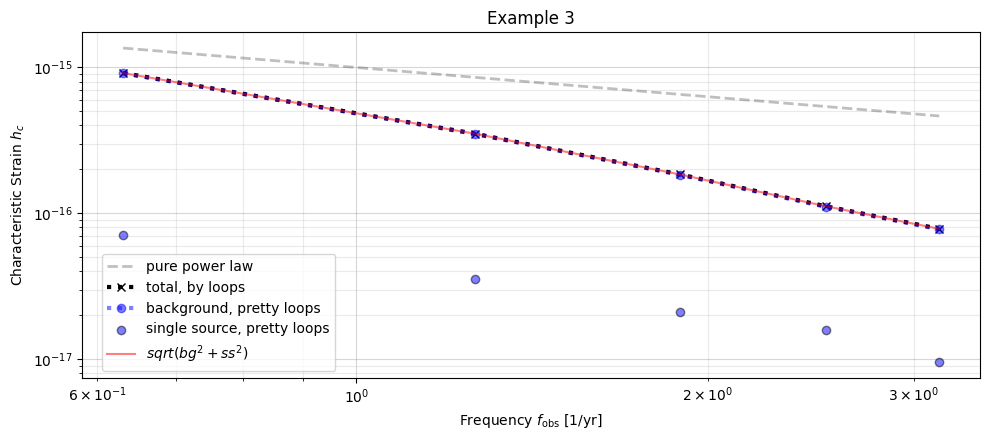

In [304]:
# quick plot
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])
ax.set_title(exname)
xx = fobs * YR
print(fobs.shape)
print(len(hc_tt))
# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# total char strain (no sources subtracted)
ax.plot(xx, hc_tt, color='black', marker = 'x', lw=3, ls = 'dotted', alpha=1, label='total, by loops')


# gwb
ax.plot(xx, hc_bg, color='b', marker = 'o', lw=3, ls = 'dotted', alpha=.5, label='background, pretty loops')
# loudest source per bin
ax.scatter(xx, hc_ss, color='b', marker = 'o', edgecolor='k', alpha=.5, label='single source, pretty loops')


# ax.plot(xx, hc_bg+hc_ss, color='r', label='bg + ss', alpha=.5)
ax.plot(xx, np.sqrt(hc_bg**2+hc_ss**2), color='r', label=r'$sqrt (bg^2 + ss^2)$', alpha=.5)

legend_gwb = ax.legend(bbox_to_anchor=(.1,.15), bbox_transform=fig.transFigure, loc='lower left')


# ax.set_ylim(1e-16, 3e-15)
fig.tight_layout()

##### number - number_bg check

(24, 24, 24)
(24, 24, 24)


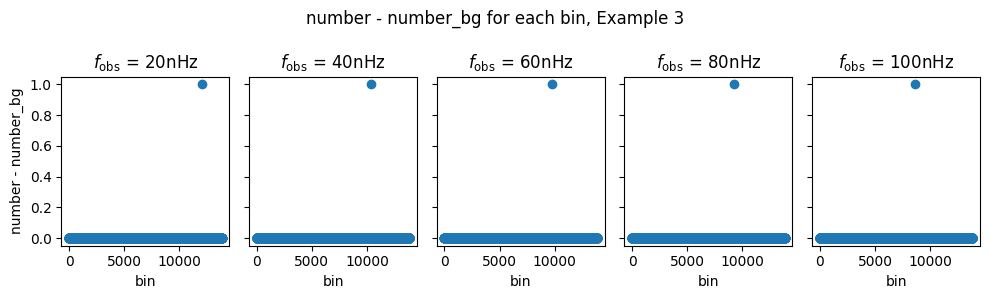

In [305]:
# plot number vs anything at 1 frequency 
freqs_in_nHz = fobs*10**9
# plot number - single sources vs anything at 1 frequency,
# should only vary in one cell
fig, ax = plt.subplots(1,len(fobs), figsize = (10,3), sharey=True)
fig.suptitle('number - number_bg for each bin, '+ exname)
ax[0].set_ylabel('number - number_bg')
bins = np.arange(0, number[...,0].size, 1)
bins = np.reshape(bins, number[...,0].shape)
print(bins.shape)
print(number[...,0].shape)
for f in range(len(fobs)):
    ax[f].scatter(bins, (number[...,f] - number_bg[...,f]))
    ax[f].set_title('$f_\mathrm{obs}$ = %dnHz' % freqs_in_nHz[f])
    ax[f].set_xlabel('bin')
fig.tight_layout()


# 4. Even More Complex Example - Casting 64bit


In [306]:
exname = 'Example 4'

## 4.1 Calculate Strains
### Choose the frequency bins at which to calculate the GWB

In [307]:
dur = 5.0*YR/3.1557600
cad = .2*YR/3.1557600
fobs = utils.nyquist_freqs(dur,cad)
fobs_edges = utils.nyquist_freqs_edges(dur,cad)
print(f"Number of frequency bins: {fobs.size-1}")
print(f"  between [{fobs[0]*YR:.2f}, {fobs[-1]*YR:.2f}] 1/yr")
print(f"          [{fobs[0]*1e9:.2f}, {fobs[-1]*1e9:.2f}] nHz")

Number of frequency bins: 11
  between [0.63, 7.57] 1/yr
          [20.00, 240.00] nHz


### Build Semi-Analytic-Model with super simple parameters 

In [308]:
mtot=(1.0e6*MSOL/1.988409870698051, (4.0e11*MSOL).astype(np.float64), 25)
mrat=(1e-1, 1.0, 25)
redz=(1e-3, 10.0, 25)
sam = holo.sam.Semi_Analytic_Model(mtot, mrat, redz)
print('edges:', sam.edges)

edges: [array([1.00e+39, 1.76e+39, 3.10e+39, 5.46e+39, 9.63e+39, 1.70e+40,
       2.99e+40, 5.26e+40, 9.27e+40, 1.63e+41, 2.87e+41, 5.06e+41,
       8.92e+41, 1.57e+42, 2.77e+42, 4.87e+42, 8.58e+42, 1.51e+43,
       2.66e+43, 4.69e+43, 8.26e+43, 1.46e+44, 2.56e+44, 4.52e+44,
       7.95e+44]), array([0.1 , 0.11, 0.12, 0.13, 0.15, 0.16, 0.18, 0.2 , 0.22, 0.24, 0.26,
       0.29, 0.32, 0.35, 0.38, 0.42, 0.46, 0.51, 0.56, 0.62, 0.68, 0.75,
       0.83, 0.91, 1.  ]), array([1.00e-03, 1.47e-03, 2.15e-03, 3.16e-03, 4.64e-03, 6.81e-03,
       1.00e-02, 1.47e-02, 2.15e-02, 3.16e-02, 4.64e-02, 6.81e-02,
       1.00e-01, 1.47e-01, 2.15e-01, 3.16e-01, 4.64e-01, 6.81e-01,
       1.00e+00, 1.47e+00, 2.15e+00, 3.16e+00, 4.64e+00, 6.81e+00,
       1.00e+01])]


### Get SAM edges and numbers as in sam.gwb()

In [309]:
# get observed orbital frequency bin edges and centers 
# from observed GW frequency bin edges
# f_orb = f_GW/2
fobs_orb_edges = fobs_edges / 2.0
fobs_orb_cents = kale.utils.midpoints(fobs_edges) / 2.0

# dynamic_binary_number
# gets differential number of binaries per bin-vol per log freq interval
edges, dnum = sam.dynamic_binary_number(holo.hardening.Hard_GW, fobs_orb=fobs_orb_cents)
edges[-1] = fobs_orb_edges

# integrate (multiply by bin volume) within each bin
number = utils._integrate_grid_differential_number(edges, dnum, freq=False)
number = number * np.diff(np.log(fobs_edges))

### Calculate strains

In [310]:
# 1. Get GW Total Strain using gws_by_ndars()
hc_tt = gws_by_loops(edges, number, realize=False, round = True, sum=True)   
 
# 2 Get bg (background) and ss (single source) strains by ss_gws_by_loops
hc_bg, hc_ss, sspar, ssidx, maxhs, number_bg = ss_gws_by_loops(edges, number, realize=False, round=True, sum=True, ss=True)

## 4.3 Test Plots

### BG, SS, and TT Strain

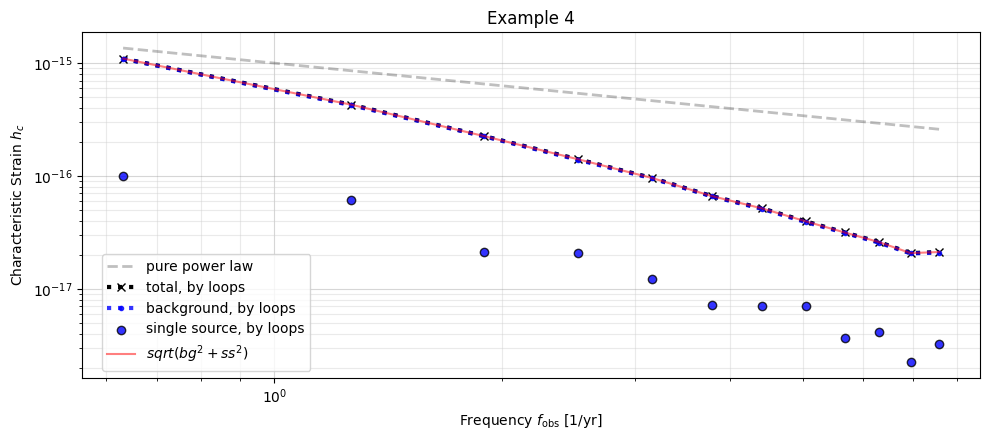

In [314]:
# quick plot
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$', figsize=[10,4.5])
ax.set_title(exname)
xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# total char strain (no sources subtracted)
ax.plot(xx, hc_tt, color='black', marker = 'x', lw=3, ls = 'dotted', alpha=1, label='total, by loops')


# gwb
ax.plot(xx, hc_bg, color='b', marker = '.', lw=3, ls = 'dotted', alpha=.8, label='background, by loops')
# loudest source per bin
ax.scatter(xx, hc_ss, color='b', marker = 'o', edgecolor='k', alpha=.8, label='single source, by loops')


# ax.plot(xx, hc_bg+hc_ss, color='r', label='bg + ss')
ax.plot(xx, np.sqrt(hc_bg**2+hc_ss**2), color='r', label=r'$sqrt (bg^2 + ss^2)$', alpha=.5)


legend_gwb = ax.legend(bbox_to_anchor=(.1,.15), bbox_transform=fig.transFigure, loc='lower left')


# ax.set_ylim(1e-16, 3e-15)
fig.tight_layout()

##### number - number_bg check

(24, 24, 24)
(24, 24, 24)


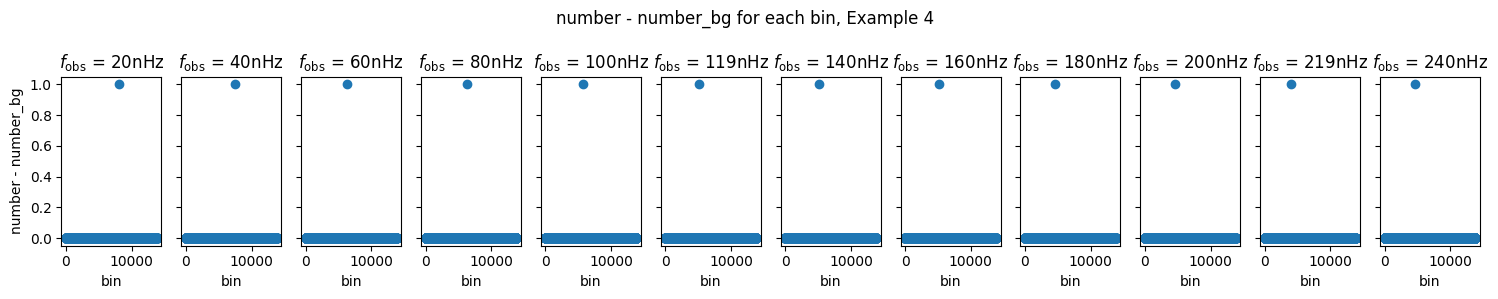

In [312]:
# plot number vs anything at 1 frequency 
freqs_in_nHz = fobs*10**9
# plot number - single sources vs anything at 1 frequency,
# should only vary in one cell
fig, ax = plt.subplots(1,len(fobs), figsize = (15,3), sharey=True)
fig.suptitle('number - number_bg for each bin, '+ exname)
ax[0].set_ylabel('number - number_bg')
bins = np.arange(0, number[...,0].size, 1)
bins = np.reshape(bins, number[...,0].shape)
print(bins.shape)
print(number[...,0].shape)
for f in range(len(fobs)):
    ax[f].scatter(bins, (number[...,f] - number_bg[...,f]))
    ax[f].set_title('$f_\mathrm{obs}$ = %dnHz' % freqs_in_nHz[f])
    ax[f].set_xlabel('bin')
fig.tight_layout()


In [313]:
test = (hc_bg**2 + hc_ss**2)
error = (test-hc_tt**2)/hc_tt**2
# np.isclose(hc_tt, )
print(error)
print(hc_tt - np.sqrt(hc_ss**2 + hc_bg**2))

[ 0.00e+00 -2.38e-16 -2.15e-16 -1.39e-16 -2.96e-16  1.55e-16 -1.28e-16
  2.18e-16 -1.71e-16  0.00e+00  0.00e+00  1.90e-16]
[ 0.00e+00  4.93e-32  0.00e+00  0.00e+00  1.23e-32  0.00e+00  0.00e+00
 -6.16e-33  0.00e+00  0.00e+00  0.00e+00  0.00e+00]


use n>0